In [ ]:
import torch
from torchvision import transforms, datasets
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from nltk.util import ngrams
from datasets import load_dataset
import numpy as np

In [ ]:
MAX_NEW_TOKENS = 100
BEAM_WIDTH = 3
TOP_K = 50
DEF_TEMP = 1
NUCLEUS_THRESH = 0.9

In [ ]:
model_name = "HuggingFaceTB/smollm2-135M-SFT-Only"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

rm_name = "OpenAssistant/reward-model-deberta-v3-large-v2"
reward_tokenizer = AutoTokenizer.from_pretrained(rm_name)
reward_model = AutoModelForSequenceClassification.from_pretrained(rm_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

In [ ]:
def get_reward_score(prompt, response):
    """Calculates scalar quality score using the Reward Model."""
    inputs = reward_tokenizer(prompt, response, return_tensors='pt').to(device)
    with torch.no_grad():
        score = reward_model(**inputs).logits[0].cpu().detach().item()
    return score

def calculate_distinct_n(text, n=2):
    tokens = text.split()
    if len(tokens) < n:
        return 0.0

    generated_ngrams = list(ngrams(tokens, n))
    total_ngrams = len(generated_ngrams)
    unique_ngrams = len(set(generated_ngrams))

    if total_ngrams == 0: return 0.0
    return unique_ngrams / total_ngrams

def greedy_search_decoding(model, tokenizer, prompt, max_new_tokens=MAX_NEW_TOKENS):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    input_len = input_ids.shape[-1]
    generated_ids = input_ids

    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(generated_ids)
            next_token_logits = outputs.logits[:, -1, :]

            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.argmax(probs, dim=-1).unsqueeze(-1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated_ids = torch.cat([generated_ids, next_token], dim=-1)

    return tokenizer.decode(generated_ids[0][input_len:], skip_special_tokens=True)

def beam_decoding(model, tokenizer, prompt, beam_width=BEAM_WIDTH, max_new_tokens=MAX_NEW_TOKENS):
    input_text = tokenizer(prompt, return_tensors="pt").to(device)
    input_ids = input_text["input_ids"]
    input_len = input_ids.shape[-1]
    output = model.generate(
            **input_text,
            max_new_tokens=max_new_tokens,
            num_beams=beam_width,
            early_stopping=True,
            do_sample=False
        )
    return tokenizer.decode(output[0][input_len:], skip_special_tokens=True)

def top_k_decoding(model, tokenizer, prompt, k=TOP_K, temp=DEF_TEMP, max_new_tokens=MAX_NEW_TOKENS):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    input_len = input_ids.shape[-1]
    generated_ids = input_ids

    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(generated_ids)
            next_token_logits = outputs.logits[:, -1, :] / temp

            top_k_logits, top_k_indices = torch.topk(next_token_logits, k)
            mask = torch.full_like(next_token_logits, float('-inf'))

            mask.scatter_(1, top_k_indices, top_k_logits)
            probs = F.softmax(mask, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated_ids = torch.cat([generated_ids, next_token], dim=-1)

    return tokenizer.decode(generated_ids[0][input_len:], skip_special_tokens=True)


def nucleus_sampling(model, tokenizer, prompt, p=NUCLEUS_THRESH, temp=DEF_TEMP, max_new_tokens=MAX_NEW_TOKENS):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    input_len = input_ids.shape[-1]
    generated_ids = input_ids

    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(generated_ids)
            next_token_logits = outputs.logits[:, -1, :] / temp

            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_indices_to_remove = cumulative_probs > p

            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)

            next_token_logits[indices_to_remove] = float('-inf')
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated_ids = torch.cat([generated_ids, next_token], dim=-1)

    return tokenizer.decode(generated_ids[0][input_len:], skip_special_tokens=True)

In [ ]:
def get_evaluation_data(num_samples=100):
    dataset = load_dataset("databricks/databricks-dolly-15k", split="train")
    open_ended_data = dataset.filter(lambda x: x['category'] in ['creative_writing'])

    subset = open_ended_data.shuffle(seed=42).select(range(num_samples))

    data_pairs = []
    for row in subset:
        if row['context']:
            prompt_text = f"{row['instruction']}\n\nContext:\n{row['context']}"
        else:
            prompt_text = row['instruction']

        reference_text = row['response']
        data_pairs.append({
            "prompt": prompt_text,
            "reference": reference_text
        })

    return data_pairs

test_prompts = get_evaluation_data()

README.md: 0.00B [00:00, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15011 [00:00<?, ? examples/s]

In [ ]:
print(f"Loaded {len(test_prompts)} prompts.")
print("Example:", test_prompts[0]["prompt"])

Loaded 100 prompts.
Example: Write a convincing letter to complain to a perfume manufacturer about a broken perfume bottle.


In [ ]:
refs = [item['reference'] for item in test_prompts]
preds = []

greedy_rewards = []
beam_rewards = []
top_k_rewards = []
nucleus_rewards = []

distinct_bn_greedy = []
distinct_bn_beam = []
distinct_bn_top_k = []
distinct_bn_nucleus = []

distinct_un_greedy = []
distinct_un_beam = []
distinct_un_top_k = []
distinct_un_nucleus = []

print("Generating scores")
for item in tqdm(test_prompts):
    output = greedy_search_decoding(model, tokenizer, item['prompt'])
    rw = get_reward_score(item['prompt'], output)
    greedy_rewards.append(rw)
    dist = calculate_distinct_n(output)
    distinct_bn_greedy.append(dist)
    dist = calculate_distinct_n(output, n=1)
    distinct_un_greedy.append(dist)

    output = beam_decoding(model, tokenizer, item['prompt'])
    rw = get_reward_score(item['prompt'], output)
    beam_rewards.append(rw)
    dist = calculate_distinct_n(output)
    distinct_bn_beam.append(dist)
    dist = calculate_distinct_n(output, n=1)
    distinct_un_beam.append(dist)

    output = top_k_decoding(model, tokenizer, item['prompt'])
    rw = get_reward_score(item['prompt'], output)
    top_k_rewards.append(rw)
    dist = calculate_distinct_n(output)
    distinct_bn_top_k.append(dist)
    dist = calculate_distinct_n(output, n=1)
    distinct_un_top_k.append(dist)

    output = nucleus_sampling(model, tokenizer, item['prompt'])
    rw = get_reward_score(item['prompt'], output)
    nucleus_rewards.append(rw)
    dist = calculate_distinct_n(output)
    distinct_bn_nucleus.append(dist)
    dist = calculate_distinct_n(output, n=1)
    distinct_un_nucleus.append(dist)
print("Done")

Generating scores


100%|██████████| 100/100 [11:00<00:00,  6.60s/it]

Done


In [ ]:
temps = [0.2, 0.5, 0.8, 1.0, 1.2]

temp_scores = {}
temp_dist = {}

for temp in temps:
    temp_distinct_bn_top_k = []
    temp_distinct_bn_nucleus = []
    temp_distinct_un_top_k = []
    temp_distinct_un_nucleus = []
    temp_top_k_rewards = []
    temp_nucleus_rewards = []
    print(f"Temp: {temp}")

    for item in tqdm(test_prompts):
        output = top_k_decoding(model, tokenizer, item['prompt'], temp=temp)
        rw = get_reward_score(item['prompt'], output)
        temp_top_k_rewards.append(rw)
        dist = calculate_distinct_n(output)
        temp_distinct_bn_top_k.append(dist)
        dist = calculate_distinct_n(output, n=1)
        temp_distinct_un_top_k.append(dist)

        output = nucleus_sampling(model, tokenizer, item['prompt'], temp=temp)
        rw = get_reward_score(item['prompt'], output)
        temp_nucleus_rewards.append(rw)
        dist = calculate_distinct_n(output)
        temp_distinct_bn_nucleus.append(dist)
        dist = calculate_distinct_n(output, n=1)
        temp_distinct_un_nucleus.append(dist)
    temp_dist[temp] = {
        "distinct_bn_top_k": temp_distinct_bn_top_k,
        "distinct_bn_nucleus": temp_distinct_bn_nucleus,
        "distinct_un_top_k": temp_distinct_un_top_k,
        "distinct_un_nucleus": temp_distinct_un_nucleus
    }
    temp_scores[temp] = {
        "top_k_rewards": temp_top_k_rewards,
        "nucleus_rewards": temp_nucleus_rewards
    }


Temp: 0.2


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


Temp: 0.5


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


Temp: 0.8


100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


Temp: 1.0


100%|██████████| 100/100 [05:02<00:00,  3.02s/it]


Temp: 1.2


100%|██████████| 100/100 [06:35<00:00,  3.96s/it]


Plot saved as 'full_analysis_3x2.png'


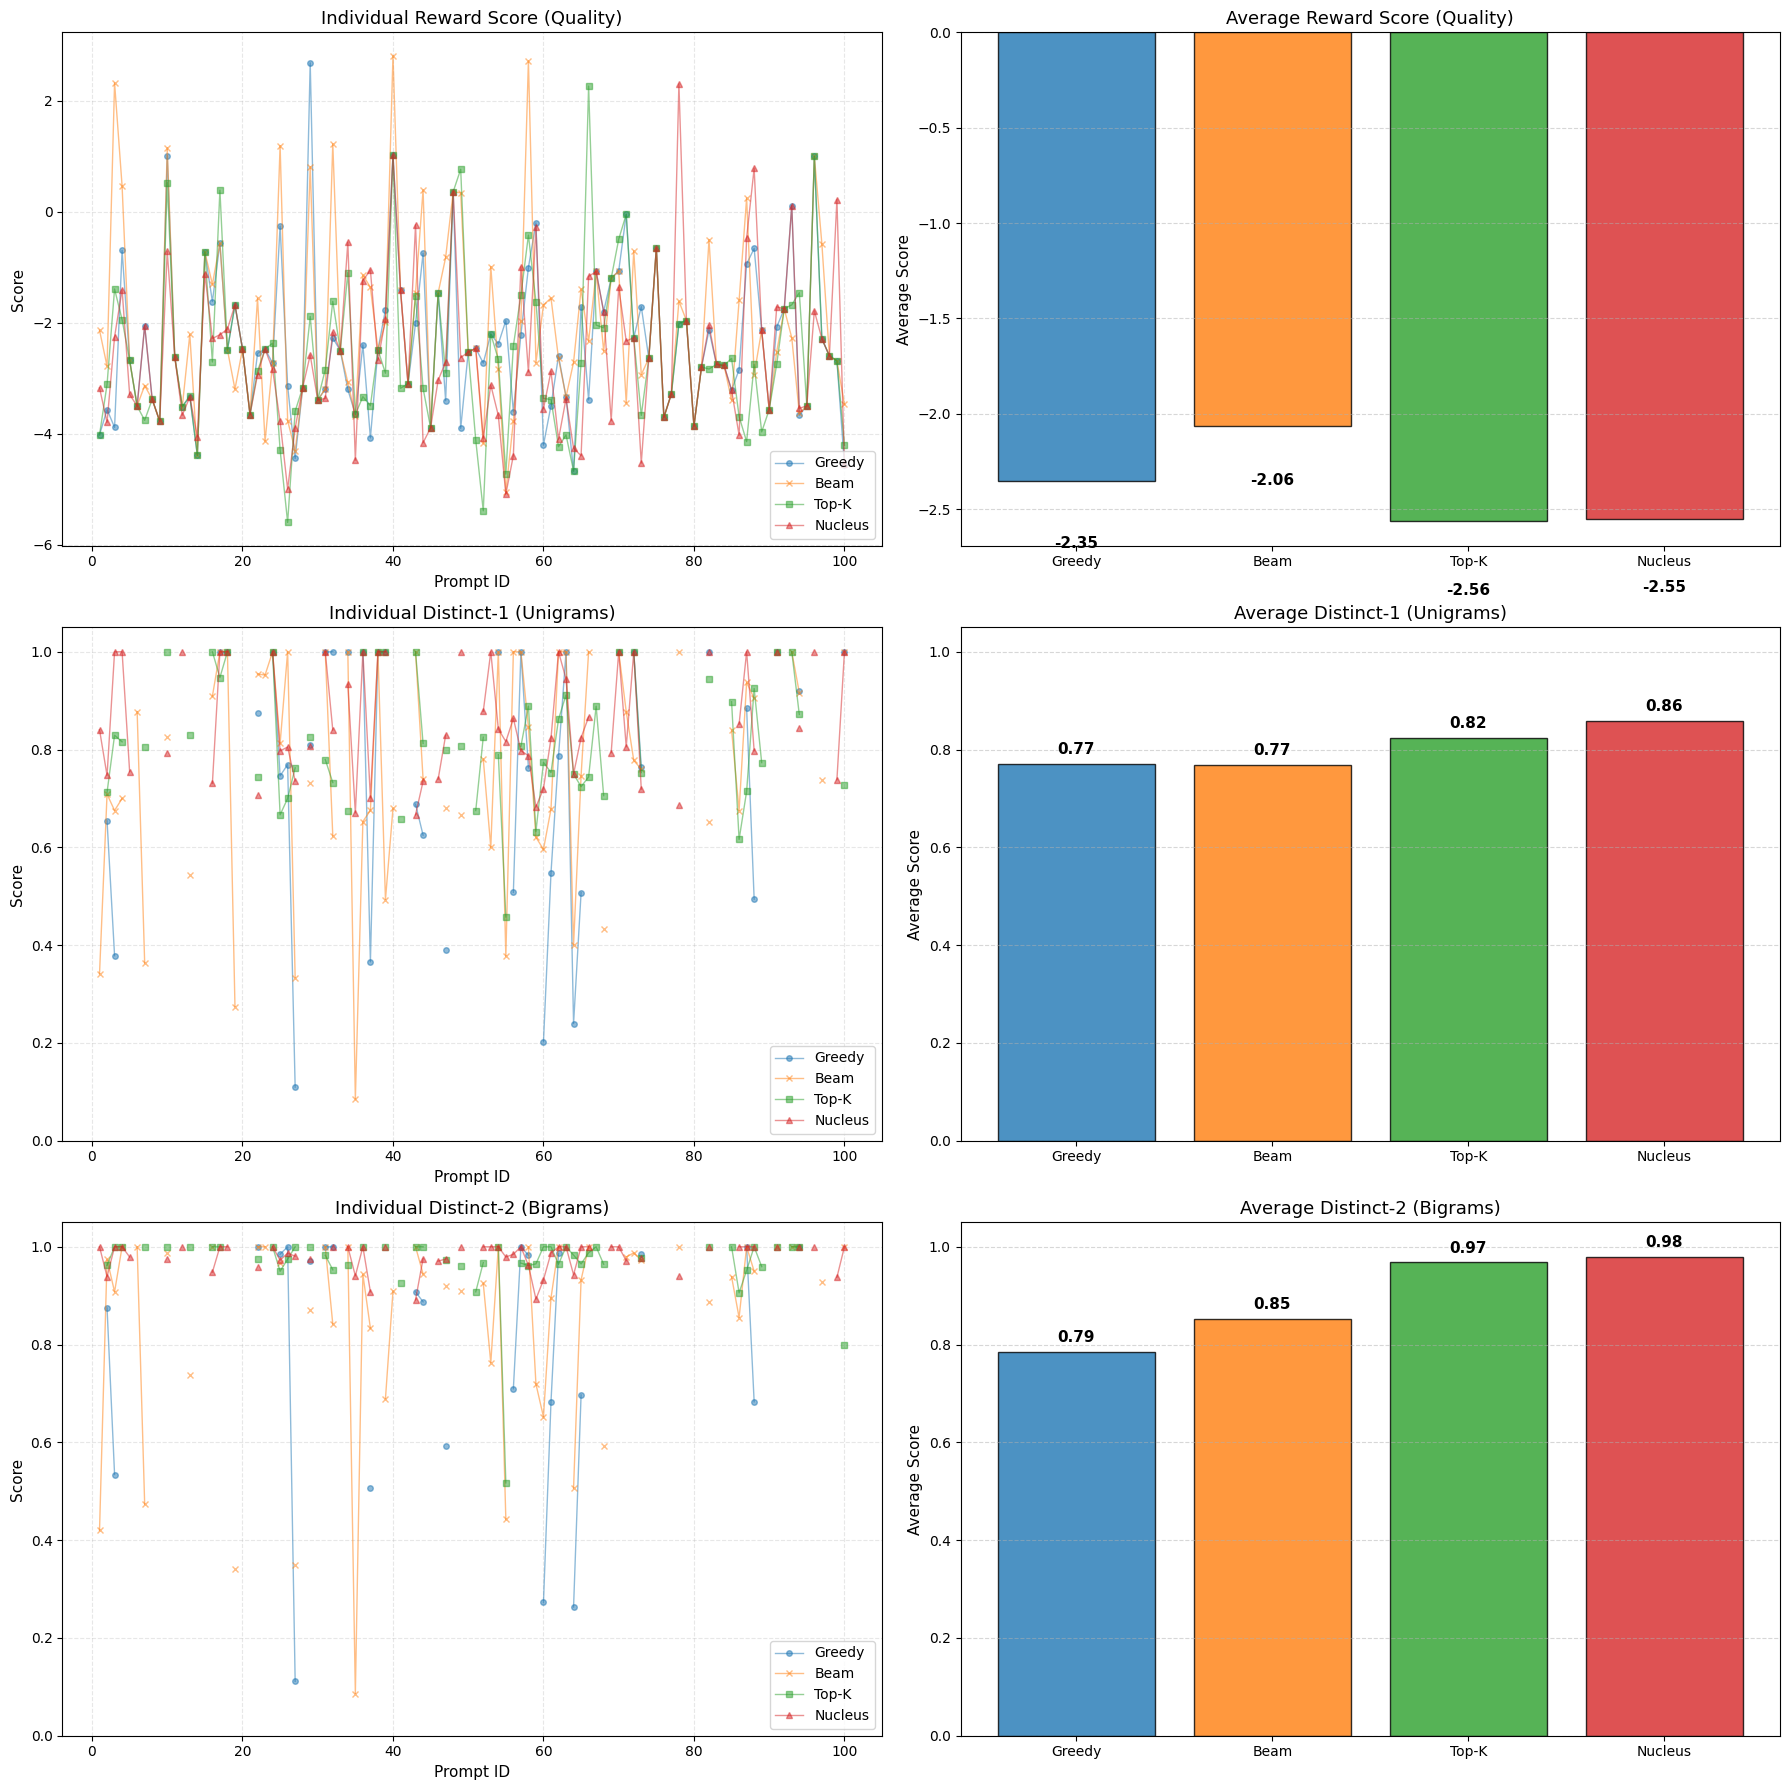

In [ ]:
all_rewards = [greedy_rewards, beam_rewards, top_k_rewards, nucleus_rewards]
all_unigrams = [distinct_un_greedy, distinct_un_beam, distinct_un_top_k, distinct_un_nucleus]
all_bigrams  = [distinct_bn_greedy, distinct_bn_beam, distinct_bn_top_k, distinct_bn_nucleus]

strategies = ['Greedy', 'Beam', 'Top-K', 'Nucleus']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 'x', 's', '^']

sample_indices = np.arange(1, len(greedy_rewards) + 1)

def mask_zeros(data):
    """Replaces 0.0 with np.nan so they don't break the line plots."""
    arr = np.array(data, dtype=float)
    arr[arr == 0.0] = np.nan
    return arr

def get_clean_mean(data):
    """Calculates mean excluding 0.0 values."""
    arr = np.array(data)
    non_zeros = arr[arr > 0.0]
    if len(non_zeros) == 0: return 0.0
    return np.mean(non_zeros)

fig, axes = plt.subplots(3, 2, figsize=(18, 18))
plt.subplots_adjust(hspace=0.4)

metrics_data = [
    {"data": all_rewards,  "title": "Reward Score (Quality)",   "ylim": None},
    {"data": all_unigrams, "title": "Distinct-1 (Unigrams)",    "ylim": (0, 1.05)},
    {"data": all_bigrams,  "title": "Distinct-2 (Bigrams)",     "ylim": (0, 1.05)}
]

for row_idx, metric in enumerate(metrics_data):
    current_data_list = metric["data"]
    title_base = metric["title"]
    y_limit = metric["ylim"]

    ax_line = axes[row_idx, 0]
    for i, strategy in enumerate(strategies):
        if "Reward" in title_base:
            plot_data = current_data_list[i]
        else:
            plot_data = mask_zeros(current_data_list[i])

        ax_line.plot(sample_indices, plot_data, marker=markers[i], label=strategy,
                     color=colors[i], alpha=0.5, linewidth=1, markersize=4)

    ax_line.set_title(f'Individual {title_base}', fontsize=13)
    ax_line.set_ylabel('Score', fontsize=11)
    ax_line.set_xlabel('Prompt ID', fontsize=11)
    ax_line.legend(loc='lower right')
    ax_line.grid(True, linestyle='--', alpha=0.3)
    if y_limit:
        ax_line.set_ylim(y_limit)
    ax_bar = axes[row_idx, 1]

    if "Reward" in title_base:
        means = [np.mean(d) for d in current_data_list]
    else:
        means = [get_clean_mean(d) for d in current_data_list]

    bars = ax_bar.bar(strategies, means, color=colors, alpha=0.8, edgecolor='black')

    ax_bar.set_title(f'Average {title_base}', fontsize=13)
    ax_bar.set_ylabel('Average Score', fontsize=11)
    ax_bar.grid(axis='y', linestyle='--', alpha=0.5)
    if y_limit:
        ax_bar.set_ylim(y_limit)

    for bar in bars:
        yval = bar.get_height()
        offset = 0.02 if yval >= 0 else -0.3
        if "Reward" in title_base and yval < 0: offset = -0.15 * abs(yval)

        ax_bar.text(bar.get_x() + bar.get_width()/2, yval + offset,
                    f"{yval:.2f}", ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('full_analysis_3x2.png', dpi=300)
print("Plot saved as 'full_analysis_3x2.png'")
plt.show()

In [ ]:
mean_rewards_k = []
mean_rewards_p = []
mean_dist1_k = []
mean_dist1_p = []
mean_dist2_k = []
mean_dist2_p = []

def get_clean_mean(data):
    """Calculates mean excluding 0.0 values (failed generations)."""
    arr = np.array(data)
    non_zeros = arr[arr > 0.001]
    if len(non_zeros) == 0: return 0.0
    return np.mean(non_zeros)


for t in temps:
    mean_rewards_k.append(np.mean(temp_scores[t]["top_k_rewards"]))
    mean_rewards_p.append(np.mean(temp_scores[t]["nucleus_rewards"]))

    # --- Diversity (Use Clean Mean) ---
    mean_dist1_k.append(get_clean_mean(temp_dist[t]["distinct_un_top_k"]))
    mean_dist1_p.append(get_clean_mean(temp_dist[t]["distinct_un_nucleus"]))

    mean_dist2_k.append(get_clean_mean(temp_dist[t]["distinct_bn_top_k"]))
    mean_dist2_p.append(get_clean_mean(temp_dist[t]["distinct_bn_nucleus"]))

# --- 2. Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

# Style Settings
styles = {'linewidth': 2.5, 'marker': 'o', 'markersize': 8}
color_k = '#2ca02c' # Green for Top-K
color_p = '#d62728' # Red for Nucleus

# --- Plot 1: Quality (Reward) ---
axes[0].plot(temps, mean_rewards_k, label='Top-K', color=color_k, **styles)
axes[0].plot(temps, mean_rewards_p, label='Nucleus (Top-P)', color=color_p, **styles)
axes[0].set_title("Quality vs. Temperature")
axes[0].set_ylabel("Average Reward Score")
axes[0].set_xlabel("Temperature")
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# --- Plot 2: Unigram Diversity ---
axes[1].plot(temps, mean_dist1_k, label='Top-K', color=color_k, **styles)
axes[1].plot(temps, mean_dist1_p, label='Nucleus (Top-P)', color=color_p, **styles)
axes[1].set_title("Unigram Diversity vs. Temperature")
axes[1].set_ylabel("Distinct-1 Score")
axes[1].set_xlabel("Temperature")
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# --- Plot 3: Bigram Diversity ---
axes[2].plot(temps, mean_dist2_k, label='Top-K', color=color_k, **styles)
axes[2].plot(temps, mean_dist2_p, label='Nucleus (Top-P)', color=color_p, **styles)
axes[2].set_title("Bigram Diversity vs. Temperature")
axes[2].set_ylabel("Distinct-2 Score")
axes[2].set_xlabel("Temperature")
axes[2].set_ylim(0, 1.05)
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

plt.suptitle("Effect of Temperature on Decoding Strategy Performance", fontsize=16, y=1.05)
plt.savefig('temperature_ablation_study.png', bbox_inches='tight')
plt.show()

--- Running Across-Prompt Diversity (N=50 prompts) ---
Generating for Greedy...


Generating for Beam...


Generating for Top-K...


Generating for Nucleus...



--- Running Within-Prompt Diversity (N=20 samples on 1 prompt) ---
Target Prompt (Truncated): Write a convincing letter to complain to a perfume...
Generating for Greedy...


Generating for Beam...


Generating for Top-K...


Generating for Nucleus...



STRATEGY   | ACROSS D-1 ACROSS D-2 | WITHIN D-1 WITHIN D-2
------------------------------------------------------------
Greedy     | 0.4093     0.6737     | 0.0000     0.0000
Beam       | 0.4246     0.7234     | 0.0171     0.0210
Top-K      | 0.5487     0.8998     | 0.4652     0.8170
Nucleus    | 0.4906     0.8745     | 0.5798     0.8681


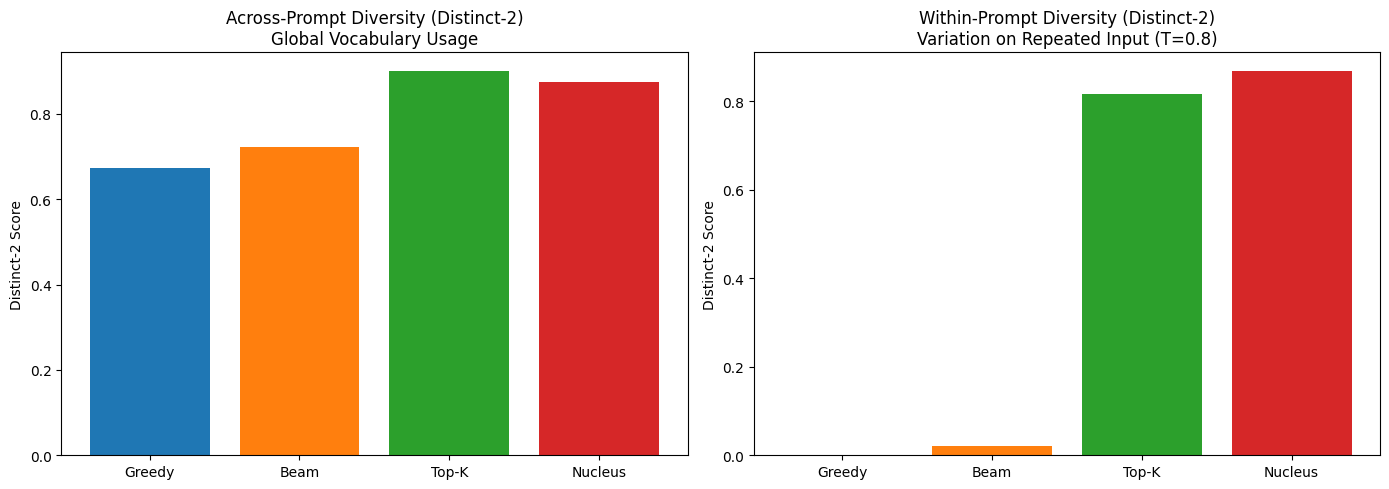

In [ ]:
def calculate_corpus_distinct_n(corpus_texts, n=2):
    all_ngrams = []

    for text in corpus_texts:
        tokens = text.split()
        if len(tokens) >= n:
            all_ngrams.extend(list(ngrams(tokens, n)))

    if len(all_ngrams) == 0:
        return 0.0

    unique_ngrams = len(set(all_ngrams))
    total_ngrams = len(all_ngrams)

    return unique_ngrams / total_ngrams

FIXED_TEMP = 0.8
NUM_WITHIN_SAMPLES = 20
ACROSS_LIMIT = 50

strategies = {
    "Greedy": lambda p: greedy_search_decoding(model, tokenizer, p),
    "Beam": lambda p: beam_decoding(model, tokenizer, p),
    "Top-K": lambda p: top_k_decoding(model, tokenizer, p, temp=FIXED_TEMP),
    "Nucleus": lambda p: nucleus_sampling(model, tokenizer, p, temp=FIXED_TEMP)
}

print(f"--- Running Across-Prompt Diversity (N={ACROSS_LIMIT} prompts) ---")
across_results = {k: [] for k in strategies.keys()}
subset_prompts = test_prompts[:ACROSS_LIMIT]

for strat_name, strat_fn in strategies.items():
    print(f"Generating for {strat_name}...")
    outputs = []
    for item in tqdm(subset_prompts, desc=strat_name, leave=False):
        outputs.append(strat_fn(item['prompt']))

    d1 = calculate_corpus_distinct_n(outputs, n=1)
    d2 = calculate_corpus_distinct_n(outputs, n=2)
    across_results[strat_name] = (d1, d2)

print(f"\n--- Running Within-Prompt Diversity (N={NUM_WITHIN_SAMPLES} samples on 1 prompt) ---")
target_prompt = test_prompts[0]['prompt']
print(f"Target Prompt (Truncated): {target_prompt[:50]}...")

within_results = {k: [] for k in strategies.keys()}

for strat_name, strat_fn in strategies.items():
    print(f"Generating for {strat_name}...")
    outputs = []
    for _ in tqdm(range(NUM_WITHIN_SAMPLES), desc=strat_name, leave=False):
        outputs.append(strat_fn(target_prompt))

    d1 = calculate_corpus_distinct_n(outputs, n=1)
    d2 = calculate_corpus_distinct_n(outputs, n=2)
    within_results[strat_name] = (d1, d2)

print("\n" + "="*60)
print(f"{'STRATEGY':<10} | {'ACROSS D-1':<10} {'ACROSS D-2':<10} | {'WITHIN D-1':<10} {'WITHIN D-2':<10}")
print("-" * 60)
for strat in strategies:
    ad1, ad2 = across_results[strat]
    wd1, wd2 = within_results[strat]
    print(f"{strat:<10} | {ad1:.4f}     {ad2:.4f}     | {wd1:.4f}     {wd2:.4f}")
print("="*60)

x = np.arange(len(strategies))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ad2_scores = [across_results[s][1] for s in strategies]
ax1.bar(strategies.keys(), ad2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_title(f"Across-Prompt Diversity (Distinct-2)\nGlobal Vocabulary Usage")
ax1.set_ylabel("Distinct-2 Score")

wd2_scores = [within_results[s][1] for s in strategies]
ax2.bar(strategies.keys(), wd2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax2.set_title(f"Within-Prompt Diversity (Distinct-2)\nVariation on Repeated Input (T={FIXED_TEMP})")
ax2.set_ylabel("Distinct-2 Score")

plt.tight_layout()
plt.show()